In [1]:
# kernal = py310_tf212


In [1]:
import tensorflow as tf 


In [2]:


print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
# from sgfmill import sgf
import glob


In [4]:
cfg = tf.compat.v1.ConfigProto() 
cfg.gpu_options.per_process_gpu_memory_fraction = 0.6 # 使用50%的GPU暫存  
session = tf.compat.v1.Session(config=cfg )

In [5]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Softmax,Dropout,MaxPooling2D,BatchNormalization ,Conv2DTranspose,Concatenate,Reshape,GlobalMaxPooling2D ,Add,Activation  ,multiply,Lambda,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras import backend as K


In [6]:

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	CA = channel_attention(cbam_feature, ratio)
	SA = spatial_attention(cbam_feature)
	
	combine = Concatenate()([CA,SA])
	
	return combine

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 9
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		


In [7]:
def inception_block(x):
    x1 = Conv2D(4, (1, 1), activation='relu', padding='same')(x)
    x1 = BatchNormalization()(x1)
    
    x3 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
    x3 = BatchNormalization()(x3)
    
    
    x9 = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x9 = Conv2D(16, (9, 9), activation='relu', padding='same')(x9)
    # x9 = Conv2D(64, (1, 1), activation='relu', padding='same')(x9)
    x9 = BatchNormalization()(x9)

    concatted  = Concatenate()([x1,x3,x9]) #,x5,x7
    
    return concatted


In [8]:

def build_model(num_input_planes=28, k=64, num_int_conv_layers=5): 
    input_layer = Input(shape=(19, 19, 18))
    
    
    # x1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_layer)
    x1 = inception_block(input_layer)
    x1 = Dropout(0.3)(x1)
    CA = channel_attention(x1, 8)
    # CA = channel_attention(CA, 16)
    x1 = Dropout(0.3)(CA)
    # x1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x1)
    t1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(x1)
    
    # x2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(t1)
    x2 = inception_block(t1)
    x2 = Dropout(0.5)(x2)
    CA = channel_attention(x2, 8)
    # CA = channel_attention(CA, 16)
    x2 = Dropout(0.5)(CA)
    # x2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x2)
    # t2 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(x2)
    
   
    p2 = MaxPooling2D((2, 2))(x2)   #x4 
    # x5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    x5 = Concatenate()([p2,x1])
    x5 = inception_block(x5)
    x5 = Dropout(0.3)(x5)
    CA = channel_attention(x5, 8)
    # CA = channel_attention(CA, 16)
    x5 = Dropout(0.3)(CA)
    # x5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x5)
    
    
    x = Conv2D(1, (1, 1), activation='linear', padding='same')(x5)    
    x = Flatten()(x)
    
    
    output_layer = Softmax()(x)
            
    return Model(inputs=input_layer, outputs=output_layer)


In [9]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19, 19, 18)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 16)   2608        ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 19, 19, 8)    1304        ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 4)    76          ['input_1[0][0]']            

In [10]:

# 第一個評估指標：最高機率的準確度
top1_acc = tf.keras.metrics.CategoricalAccuracy(name='top1_acc')

# 第二個評估指標：最高機率的前五個準確度
def top5_acc(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

def top10_acc(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)


In [11]:
# 編譯模型

# opt = tf.keras.optimizers.SGD(learning_rate = 0.0003)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001) #1e-4

# model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt,
              loss='categorical_crossentropy', #loss=tf.keras.losses.BinaryFocalCrossentropy(),          #loss='categorical_crossentropy',
              metrics=[top1_acc, top5_acc,top10_acc])


In [12]:
from keras.callbacks import ModelCheckpoint,CSVLogger

weight_file = '1122_newf18_batch100000_uptodown'

val_top1_acc='weight/Dan/' + weight_file + '/val_top1_acc_{val_top1_acc:.4f}.hdf5'
val_top5_acc='weight/Dan/'+ weight_file +'/val_top5_acc_{val_top5_acc:.4f}.hdf5'
val_top10_acc='weight/Dan/'+ weight_file +'/val_top10_acc_{val_top10_acc:.4f}.hdf5'
val_loss='weight/Dan/'+ weight_file +'/val_loss_{val_loss:.4f}.hdf5'


checkpoint1 = ModelCheckpoint(val_top1_acc, monitor='val_top1_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max') #,period=1
checkpoint2 = ModelCheckpoint(val_top5_acc, monitor='val_top5_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
# checkpoint3 = ModelCheckpoint(val_top10_acc, monitor='val_top10_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
checkpoint4 = ModelCheckpoint(val_loss, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

csv_logger = CSVLogger('weight/Dan/'+ weight_file +'/training_log.csv', append=True)


callbacks_list = [checkpoint1,checkpoint4,csv_logger] #,checkpoint3,checkpoint4

In [13]:
import matplotlib.pyplot as plt
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc1 = hist.history['top1_acc']
    tr_acc5 = hist.history['top5_acc']
    tr_loss = hist.history['loss']
    
    val_acc1 = hist.history['val_top1_acc']
    val_acc5 = hist.history['val_top5_acc']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    
    index_acc = np.argmax(val_acc1)
    acc_highest = val_acc1[index_acc]
    
    index_acc5 = np.argmax(val_acc5)
    acc5_highest = val_acc5[index_acc5]
    
    Epochs = [i+1 for i in range(len(tr_acc1))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'Top1 best epoch= {str(index_acc + 1)}'
    acc5_label = f'Top5 best epoch= {str(index_acc5 + 1)}'
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.ylim(-1,2.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc1, 'r', label= 'TOP1 Training Accuracy')
    plt.plot(Epochs, val_acc1, 'g', label= 'TOP1 Validation Accuracy')
    
    plt.plot(Epochs, tr_acc5, 'c', label= 'TOP5 Training Accuracy')
    plt.plot(Epochs, val_acc5, 'pink', label= 'TOP5 Validation Accuracy')
    
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.scatter(index_acc5 + 1 , acc5_highest, s= 150, c= 'red', label= acc5_label)
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout
    # plt.savefig('weight/Dan/'+weight_file + '/no' + str(NPZnum) +'NPZ.png')
    plt.show()
    

In [14]:

loaded_data = np.load('E:/research/AIcup_GO/TrainingData/organize/Dan/Design_feature_NPZ/1118_Dan_newf18_fix/Dan_train_dataset5_feature18_batch100000_0.npz')
x_train = loaded_data['x_train']
y_train = loaded_data['y_train']
x_train.shape ,y_train.shape

((100000, 2, 18, 19, 19), (100000, 2, 1, 19, 19))

In [15]:
x_train = x_train.reshape(-1, 18, 19, 19)
x_train.shape 

(200000, 18, 19, 19)

In [16]:
x_train = x_train.transpose(( 0, 2, 3 ,1))
x_train.shape

(200000, 19, 19, 18)

In [17]:
y_train = y_train.reshape(-1,361)
y_train.shape


(200000, 361)

In [18]:
loaded_data = np.load('E:/research/AIcup_GO/TrainingData/organize/Dan/Design_feature_NPZ/1118_Dan_newf18_fix/Dan_train_dataset5_feature18_batch100000_100000.npz')
x_test = loaded_data['x_train']
y_test = loaded_data['y_train']
x_test.shape ,y_test.shape

((160, 2, 18, 19, 19), (160, 2, 1, 19, 19))

In [19]:
x_test = x_test.reshape(-1, 18, 19, 19)
x_test = x_test.transpose(( 0, 2, 3 ,1))
y_test = y_test.reshape(-1,361)
x_test.shape ,y_test.shape

((320, 19, 19, 18), (320, 361))

Epoch 1/100
3125/3125 [==============================] - ETA: 0s - loss: 3.7029 - top1_acc: 0.1896 - top5_acc: 0.4790 - top10_acc: 0.6058
Epoch 1: val_top1_acc improved from -inf to 0.32500, saving model to weight/Dan/1122_newf18_batch100000_uptodown\val_top1_acc_0.3250.hdf5

Epoch 1: val_loss improved from inf to 2.88583, saving model to weight/Dan/1122_newf18_batch100000_uptodown\val_loss_2.8858.hdf5
3125/3125 [==============================] - 135s 41ms/step - loss: 3.7029 - top1_acc: 0.1896 - top5_acc: 0.4790 - top10_acc: 0.6058 - val_loss: 2.8858 - val_top1_acc: 0.3250 - val_top5_acc: 0.6313 - val_top10_acc: 0.7031
Epoch 2/100
3124/3125 [============================>.] - ETA: 0s - loss: 2.8834 - top1_acc: 0.3141 - top5_acc: 0.6419 - top10_acc: 0.7470
Epoch 2: val_top1_acc improved from 0.32500 to 0.35313, saving model to weight/Dan/1122_newf18_batch100000_uptodown\val_top1_acc_0.3531.hdf5

Epoch 2: val_loss improved from 2.88583 to 2.67974, saving model to weight/Dan/1122_newf18_b

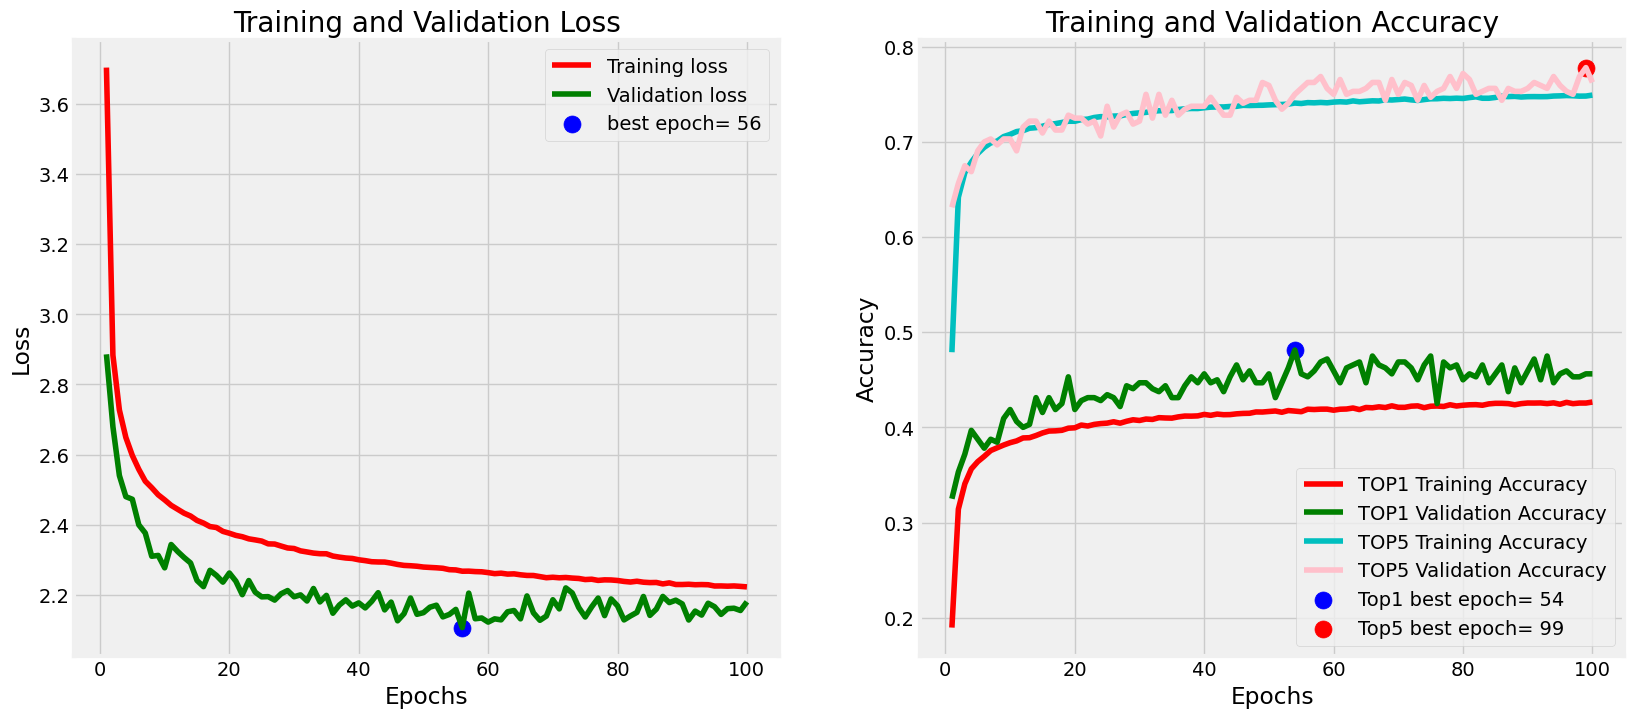

In [23]:
#data batch1
history = model.fit(x_train, y_train, epochs=100, batch_size=64,callbacks=callbacks_list, verbose=1,validation_data=(x_test,y_test)) #,validation_split=0.2
plot_training(history)
model.save('weight/Dan/'+ weight_file +'/final_weight.hdf5')
    
# 28 mins    
    

In [24]:
model.save('weight/Dan/'+ weight_file +'/final_weight.hdf5')

In [5]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import load_model

custom_objects = {'top5_acc': TopKCategoricalAccuracy(k=5)}


In [12]:
def score(Top1acc, Top5acc):
    final = Top1acc*0.25 + Top5acc*0.1
    # print("Top1 accuracy:", Top1acc)
    # print("Top5 accuracy:", Top5acc)
    print('單項加權分:' ,final)
    # return final

In [13]:
# 假設 x_test 和 y_test 是您的測試數據和標籤
results = model.evaluate(x_test, y_test)
print("Test loss:", results[0])
print("Top1 accuracy:", results[1])
print("Top5 accuracy:", results[2])

282/282 [==============================] - 56s 112ms/step - loss: 2.5629 - top1_acc: 0.4110 - top5_acc: 0.7010 - top10_acc: 0.7886
Test loss: 2.5629191398620605
Top1 accuracy: 0.41100001335144043
Top5 accuracy: 0.7009797096252441


In [14]:
predictions = model.predict(x_test)

282/282 [==============================] - 52s 184ms/step


In [17]:
predictions.shape,y_test.shape

((9000, 361), (9000, 361))

In [30]:
predictions[0]

array([6.51183685e-09, 3.85217390e-06, 1.46078307e-07, 5.28178862e-06,
       2.32685224e-07, 3.74127382e-07, 1.10911401e-06, 4.81141242e-08,
       7.36038433e-04, 3.96300660e-04, 6.62726210e-03, 3.93246040e-02,
       8.86163752e-15, 9.04983222e-01, 1.86058751e-05, 1.54341087e-05,
       3.65932948e-07, 4.32047592e-10, 6.48123943e-10, 2.93078396e-04,
       3.58936080e-12, 4.44125395e-13, 9.35423071e-13, 1.10999674e-04,
       3.16376012e-04, 5.82054405e-08, 2.29327256e-12, 1.08450990e-08,
       4.21444184e-07, 6.20489893e-03, 3.08940944e-05, 7.53256924e-09,
       2.12733950e-02, 8.70039035e-03, 2.71649424e-06, 6.70443433e-06,
       8.71663906e-06, 1.80777615e-08, 5.76058028e-07, 3.43798855e-13,
       6.70263714e-12, 1.35962699e-11, 1.15685738e-12, 3.64847841e-09,
       3.32129401e-16, 2.88347232e-12, 1.92724330e-12, 5.79343995e-12,
       3.74340070e-09, 1.58025523e-10, 1.46273380e-12, 6.55818940e-06,
       2.09180595e-04, 3.50642735e-12, 1.28454194e-05, 1.41913943e-05,
      

<function matplotlib.pyplot.show(close=None, block=None)>

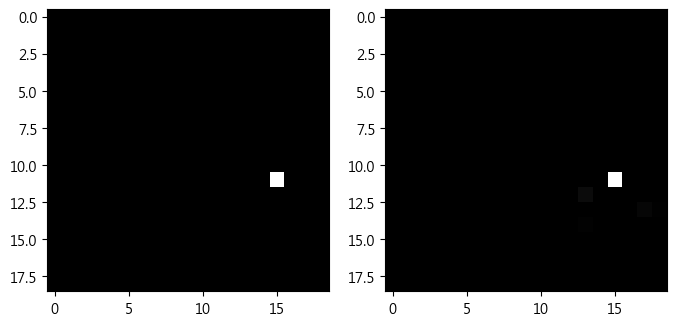

In [53]:
i=14
plt.figure(figsize= (8, 4))
plt.subplot(1, 2, 1)
y_true = y_test[i].reshape(19,19)
plt.imshow(np.flipud(y_true),cmap='gray') 
plt.subplot(1, 2, 2)
y_show = predictions[i].reshape(19,19)
plt.imshow(np.flipud(y_show),cmap='gray') #np.rot90(BO, k = 0)
plt.show

In [21]:
predicted_indices = np.argmax(predictions, axis=1)
true_indices = np.argmax(y_test, axis=1)

In [54]:
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties as font
# 設定字型的路徑
# font1 = font(fname="/content/drive/MyDrive/Colab Notebooks/font/NotoSansTC-Regular.otf")
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize= (16, 16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[ 2  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  1]]


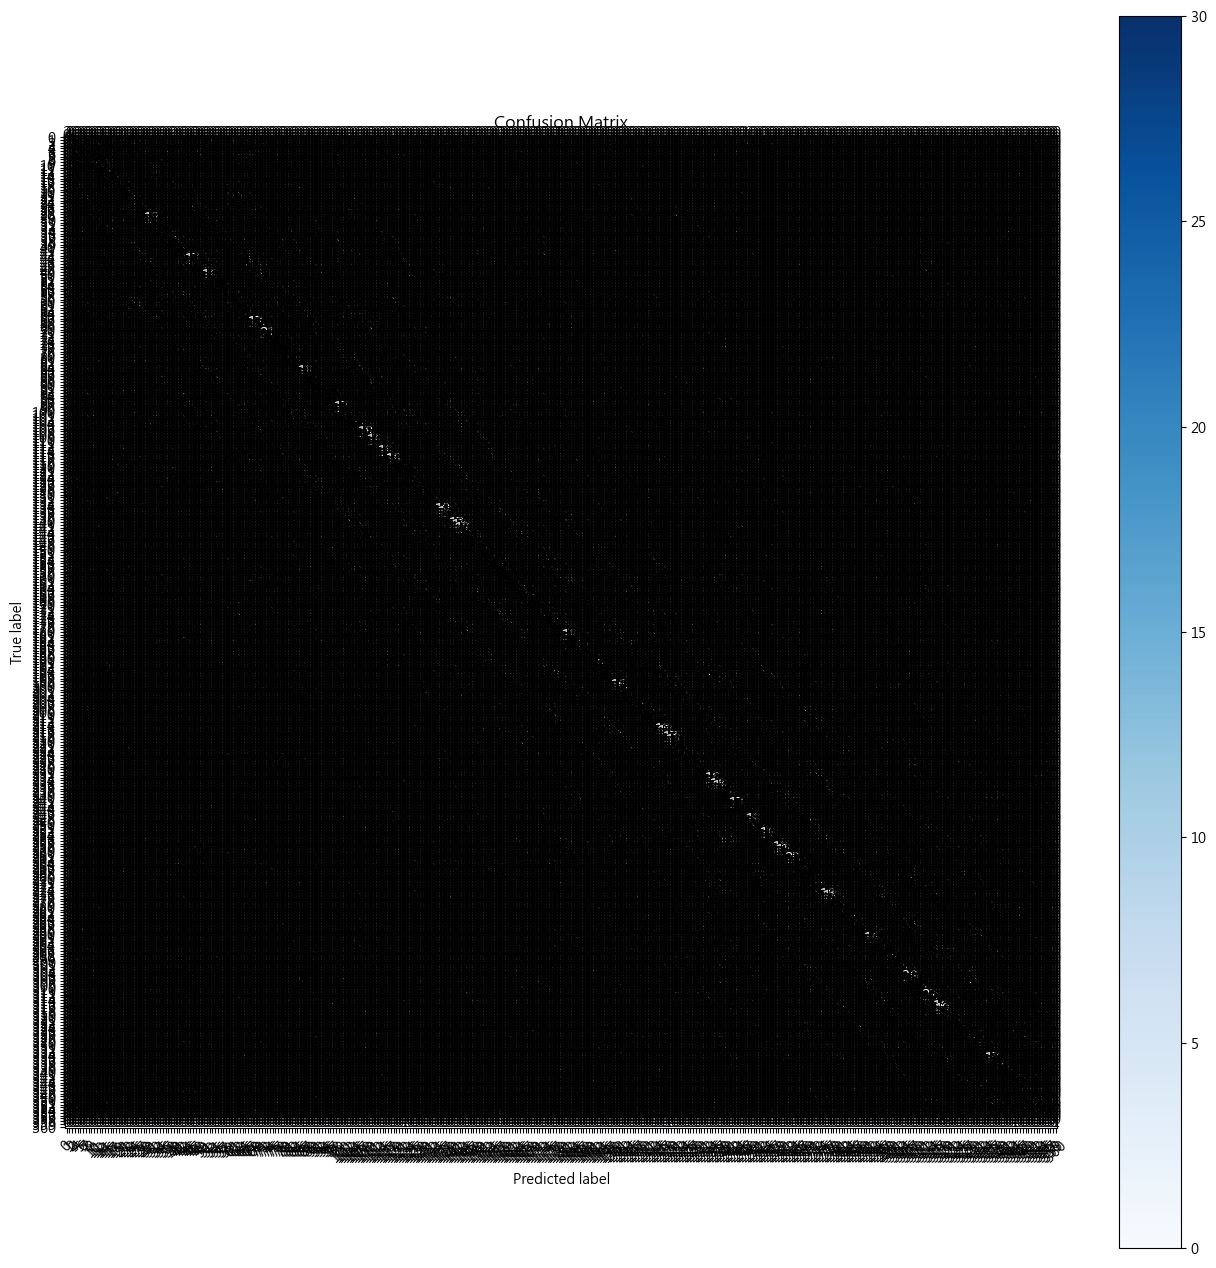

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_indices, predicted_indices)
cm_plot_labels = [x for x in range(0,361)]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [28]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_indices, predicted_indices)
print(report)  

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.40      0.57      0.47         7
           2       0.33      0.44      0.38         9
           3       0.25      0.25      0.25         8
           4       0.33      0.27      0.30        11
           5       0.46      0.50      0.48        22
           6       0.00      0.00      0.00         8
           7       0.48      0.61      0.54        18
           8       0.43      0.50      0.46        12
           9       0.50      0.39      0.44        18
          10       0.40      0.32      0.35        19
          11       0.29      0.29      0.29         7
          12       0.47      0.44      0.45        16
          13       0.69      0.55      0.61        20
          14       0.50      0.69      0.58        13
          15       0.50      0.40      0.44        15
          16       0.36      0.40      0.38        10
          17       0.33    

In [ ]:

# 假設您已經訓練了一個模型並將其儲存為 `model`
# 假設 `x_test` 是您的測試數據

# 獲得預測結果
predictions = model.predict(X_test)

# 對於每一個預測結果，找出機率最高的 top1 和 top5 的索引
top1_indices = np.argmax(predictions, axis=-1)
top5_indices = np.argsort(predictions, axis=-1)[:, -5:]

# 輸出 top1 和 top5 的預測結果
print("Top1 Predicted Indices: ", top1_indices)
print("Top5 Predicted Indices: ", top5_indices)



In [ ]:
# 如果您想將這些索引轉換為棋盤上的座標（例如，(row, col) 格式）
top1_coordinates = [(idx // 19, idx % 19) for idx in top1_indices]
top5_coordinates = [[(idx // 19, idx % 19) for idx in top5] for top5 in top5_indices]

# 輸出轉換後的座標
print("Top1 Predicted Coordinates: ", top1_coordinates)
print("Top5 Predicted Coordinates: ", top5_coordinates)
